# P-Net Example Notebook: SKCM tumor purity prediction

Imports:

In [1]:
import pnet_loader
import util
import torch
import seaborn as sns
import pandas as pd
import numpy as np
import Pnet
import random
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import os
import warnings
warnings.filterwarnings('ignore')


%load_ext autoreload
%autoreload 2

### Load Input

In [30]:
datapath='/mnt/disks/pancan/data/'
rna, cna, tumor_type = util.load_tcga_dataset(datapath+'skcm_tcga_pan_can_atlas_2018')
genetic_data = {'rna': rna, 'cna': cna}                         # Bring input into dictionary shape

In [31]:
cna.head()

Hugo_Symbol,SLA2,TAF12,BCL2,FBXO2,AMOTL2,NBPF9,FAM110C,AKR1B10,SOX7,PATL1,...,MS4A1,KC6,KANK1,PLLP,FGF13,NBAS,TDRD1,FATE1,RIMS3,CD36
TCGA-3N-A9WB-06,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
TCGA-3N-A9WC-06,0.0,1.0,0.0,1.0,0.0,0.0,-1.0,0.0,-1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,-1.0,-1.0,0.0,0.0,0.0
TCGA-3N-A9WD-06,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,1.0,0.0
TCGA-BF-AAP0-06,1.0,1.0,-1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,-1.0,-1.0,0.0,0.0,0.0,-1.0,0.0,-1.0,1.0
TCGA-D3-A1Q1-06,1.0,-1.0,-1.0,-1.0,0.0,1.0,1.0,1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,0.0,-1.0,1.0,-1.0,0.0,0.0,1.0


### Load Target

In [32]:
purity_TCGA = pd.read_csv(datapath+'TCGA_mastercalls.abs_tables_JSedit.fixed.txt', delimiter='\t').set_index('array')
purity = pd.DataFrame(purity_TCGA.join(rna, how='inner')['purity'])

In [33]:
purity.head()

,purity
TCGA-3N-A9WB-06,0.91
TCGA-3N-A9WC-06,0.58
TCGA-3N-A9WD-06,0.45
TCGA-BF-A1PU-01,0.92
TCGA-BF-A1PV-01,0.92


## Run pnet

In [34]:
import Pnet

In [35]:
canc_genes = list(pd.read_csv('../../pnet_database/genes/cancer_genes_demo.txt'))
canc_genes[:5]

['ANK1', 'CD274', 'EIF4A2', 'GATA2', 'MUC16']

In [37]:
model, train_scores, test_scores, train_dataset, test_dataset = Pnet.run(genetic_data,
                                                                         purity,
                                                                         gene_set=canc_genes)

Task defined: REG 
 if this is not the intended task please specify task
Given 2 Input modalities
Found 357 overlapping indicies
Initializing Train Dataset
Found 626 overlapping genes
generated input DataFrame of size (286, 1252)
Initializing Test Dataset
Found 626 overlapping genes
generated input DataFrame of size (71, 1252)
Found 626 overlapping genes
Loss function used: MSELoss()
We are sending to cuda
Hit early stopping criteria


In [38]:
x_train = train_dataset.x
additional_train = train_dataset.additional
y_train = train_dataset.y
x_test = test_dataset.x
additional_test = test_dataset.additional
y_test = test_dataset.y

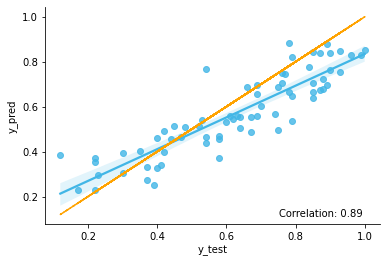

In [39]:
model.to('cpu')

y_pred = model.predict(x_test, additional_test).detach()

df = pd.DataFrame(index=test_dataset.input_df.index)
df['y_test'] = y_test
df['y_pred'] = y_pred

sns.regplot(data=df, x='y_test', y='y_pred', color='#41B6E6')
correlation_coefficient = round(df['y_test'].corr(df['y_pred']), 2)
plt.text(0.95, 0.05, f'Correlation: {correlation_coefficient}', ha='right', va='center', transform=plt.gca().transAxes)
plt.plot(y_test, y_test, color='#FFA300', linestyle='--', label='Diagonal Line')
sns.despine()
plt.show()

In [41]:
gene_feature_importances, additional_feature_importances, gene_importances, layer_importance_scores = model.interpret(test_dataset)

In [43]:
gene_importances.mean().sort_values(ascending=False).nlargest(10)

CDKN2A    0.012656
NRG1      0.006332
CBL       0.004009
NTRK3     0.003843
PIM1      0.003529
KCNJ5     0.003264
NTRK1     0.003238
RANBP2    0.003146
GPC5      0.003139
HMGA1     0.002676
dtype: float32

### External Validation

#### Data Loading

In [44]:
rna_ext_val = pd.read_csv('/mnt/disks/pancan/data/mel_dfci_2019/data_RNA_Seq_expression_tpm_all_sample_Zscores.txt',
                          delimiter='\t').set_index('Hugo_Symbol').T.drop('Entrez_Gene_Id').dropna(axis=1)
cna_ext_val = pd.read_csv('/mnt/disks/pancan/data/mel_dfci_2019/data_CNA.txt',
                          delimiter='\t').set_index('Hugo_Symbol').T.dropna(axis=1)

ext_val = pd.read_csv('/mnt/disks/pancan/data/mel_dfci_2019/data_clinical_sample.txt',
                             delimiter='\t').set_index('Sample Identifier').iloc[4:]

ext_val_target = ext_val['Purity'].astype('float')

inds = pnet_loader.get_indicies(genetic_data = {'rna': rna_ext_val, 'cna': cna_ext_val},
                                target=ext_val_target)

ext_val_dataset = pnet_loader.PnetDataset(genetic_data = {'rna': rna_ext_val,
                                                          'cna': cna_ext_val},
                                          target=ext_val_target, indicies=inds, gene_set=canc_genes)

x_val = ext_val_dataset.x
additional_val = ext_val_dataset.additional
y_val = ext_val_dataset.y

Found 121 overlapping indicies
Found 626 overlapping genes
generated input DataFrame of size (121, 1252)


#### Predict Validation Samples

In [45]:
y_pred = model.predict(x_val, additional_val).detach()

#### Plot Validation Samples

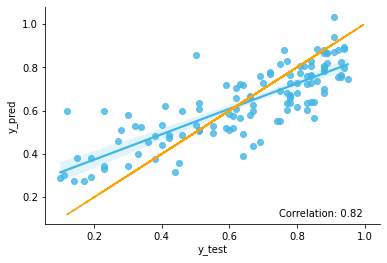

In [46]:
df = pd.DataFrame(index=ext_val_dataset.input_df.index)
df['y_test'] = y_val
df['y_pred'] = y_pred

sns.regplot(data=df, x='y_test', y='y_pred', color='#41B6E6')
correlation_coefficient = round(df['y_test'].corr(df['y_pred']), 2)
plt.text(0.95, 0.05, f'Correlation: {correlation_coefficient}', ha='right', va='center', transform=plt.gca().transAxes)
plt.plot(y_test, y_test, color='#FFA300', linestyle='--', label='Diagonal Line')
sns.despine()
plt.show()